# Machine Learning with Python

The aim of this lab is to implement a complete ML project in python going through the steps of data exploration, cleaning and transformation followed by model training and selection.

The aim is to predict median house value of neighborhoods.

## Setup
Install libraries and download required files.

In [277]:
import sys
assert sys.version_info >= (3, 9) # You might later get errors if you have a lower version.

# Install necessary libraries
!pip install sklearn matplotlib numpy pandas xgboost

# Do all necessary imports
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [15 lines of output]
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands.
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip install sklearn'
  - replace 'sklearn' by 'scikit-learn' in your pip requirements files
    (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
  - if the 'sklearn' package is used by one of your dependencies,
    it would be great if you take some time to track which package uses
    'sklearn' instead of 'scikit-learn' and report it to their issue tracker
  - as a last resort, set the environment variable
    SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
  
  More information is available at
  https://github.com/scikit-learn/sklearn-pypi-package
  [end of output]
  
  note: This error originates from a subpr

In [2]:
# Download necessary files
import tarfile
import urllib.request


# Download data file
root_url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
housing_url = f"{root_url}datasets/housing/housing.tgz"
tgz_path = "housing.tgz"
urllib.request.urlretrieve(housing_url, tgz_path)
housing_tgz = tarfile.open(tgz_path)
housing_tgz.extractall(path="./")
housing_tgz.close()

## Preliminary
Before we begin, we  split our data into a training and a testing set. All our learning will be done on the training set. 

In [3]:
# Import splitting function
from sklearn.model_selection import train_test_split

# Read data
data = pd.read_csv("housing.csv")

# Split data. 80% is used as training; 20% as testing. The data will be randomly split
train_set, test_set = train_test_split(data, test_size=0.2, random_state=37)

print(f"data size={len(data)}; training size={len(train_set)}; testing size={len(test_set)}")

data size=20640; training size=16512; testing size=4128


## Data Exploration/Preparation

In [4]:
# Read data, and take look at the attributes
housing = train_set # Rename for convenience
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
9694,-121.63,36.68,24.0,2591.0,739.0,3243.0,702.0,2.1766,108500.0,<1H OCEAN
18859,-122.09,41.32,52.0,4019.0,824.0,1728.0,706.0,2.2462,62900.0,INLAND
11074,-117.86,33.80,34.0,1793.0,480.0,1722.0,441.0,2.8235,153100.0,<1H OCEAN
10858,-117.86,33.71,36.0,191.0,42.0,208.0,37.0,3.3750,157500.0,<1H OCEAN
16462,-121.27,38.11,11.0,3163.0,794.0,2106.0,762.0,2.4482,103000.0,INLAND


Each row contains housing data aggregated by *block group*, which is how the US officially reports housing data. Our goal is to predict the median house value given information about a block. Let's take a look at the columns within the dataframe.

In [5]:
# Info gives a quick summary
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 9694 to 1935
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16345 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


First, note that the `total_bedrooms` columns contains missing values.  


---

We also note that `ocean_proximity` is categorical. 

In [6]:
print(housing.ocean_proximity.unique())

['<1H OCEAN' 'INLAND' 'NEAR BAY' 'NEAR OCEAN' 'ISLAND']


We will use one hot encoding for this feature.



In [89]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Get columns to transform.
categorical_col_names = ['ocean_proximity'] # stored as a separate variable for later.
categorical = housing[categorical_col_names]

numerical_col_names = [c for c in housing.columns if c != 'ocean_proximity' and c != 'median_house_value'] # stored as a separate variable for later.
numerical = housing[numerical_col_names]

target = housing.median_house_value

# Categorical Transformations
categorical_pipeline = Pipeline([
    ("one_hot_encoder", OneHotEncoder()),
])

# Numerical Transformations
numerical_pipeline = Pipeline([
    ("imputer", IterativeImputer())
])

numerical_pipeline_scale = Pipeline([
    ("imputer", IterativeImputer()),
    ("scaler", StandardScaler())
])


# Full transformation
feature_transformer = ColumnTransformer([
    # Categorical
    ("categorical", categorical_pipeline, categorical_col_names),
    # Numerical
    ("numerical", numerical_pipeline, numerical_col_names),
])

feature_transformer_scale = ColumnTransformer([
    # Categorical
    ("categorical", categorical_pipeline, categorical_col_names),
    # Numerical
    ("numerical", numerical_pipeline_scale, numerical_col_names),
])

housing_prepped = pd.DataFrame(feature_transformer.fit_transform(housing), columns=['<1H_OCEAN', 'INLAND', 'ISLAND', 'NEAR_BAY', 'NEAR_OCEAN']+list(numerical_col_names))
housing_prepped_scaled = pd.DataFrame(feature_transformer_scale.fit_transform(housing), columns=['<1H_OCEAN', 'INLAND', 'ISLAND', 'NEAR_BAY', 'NEAR_OCEAN']+list(numerical_col_names))
housing_prepped['median_house_value'] = housing_prepped_scaled['median_house_value'] = list(target)
housing_prepped

,<1H_OCEAN,INLAND,ISLAND,NEAR_BAY,NEAR_OCEAN,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,1.0,0.0,0.0,0.0,0.0,-121.63,36.68,24.0,2591.0,739.0,3243.0,702.0,2.1766,108500.0
1,0.0,1.0,0.0,0.0,0.0,-122.09,41.32,52.0,4019.0,824.0,1728.0,706.0,2.2462,62900.0
2,1.0,0.0,0.0,0.0,0.0,-117.86,33.80,34.0,1793.0,480.0,1722.0,441.0,2.8235,153100.0
3,1.0,0.0,0.0,0.0,0.0,-117.86,33.71,36.0,191.0,42.0,208.0,37.0,3.3750,157500.0
4,0.0,1.0,0.0,0.0,0.0,-121.27,38.11,11.0,3163.0,794.0,2106.0,762.0,2.4482,103000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,0.0,1.0,0.0,0.0,0.0,-117.35,33.96,25.0,2396.0,316.0,951.0,314.0,8.2405,235200.0
16508,1.0,0.0,0.0,0.0,0.0,-118.22,34.14,52.0,1388.0,271.0,735.0,239.0,3.7404,247700.0
16509,0.0,1.0,0.0,0.0,0.0,-121.86,37.70,13.0,9621.0,1344.0,4389.0,1391.0,6.6827,313700.0
16510,0.0,1.0,0.0,0.0,0.0,-117.78,34.58,6.0,10263.0,1864.0,6163.0,1781.0,3.8803,120000.0


Now let us inspect each feature and observe their correlation with the target variable as well as with each other.

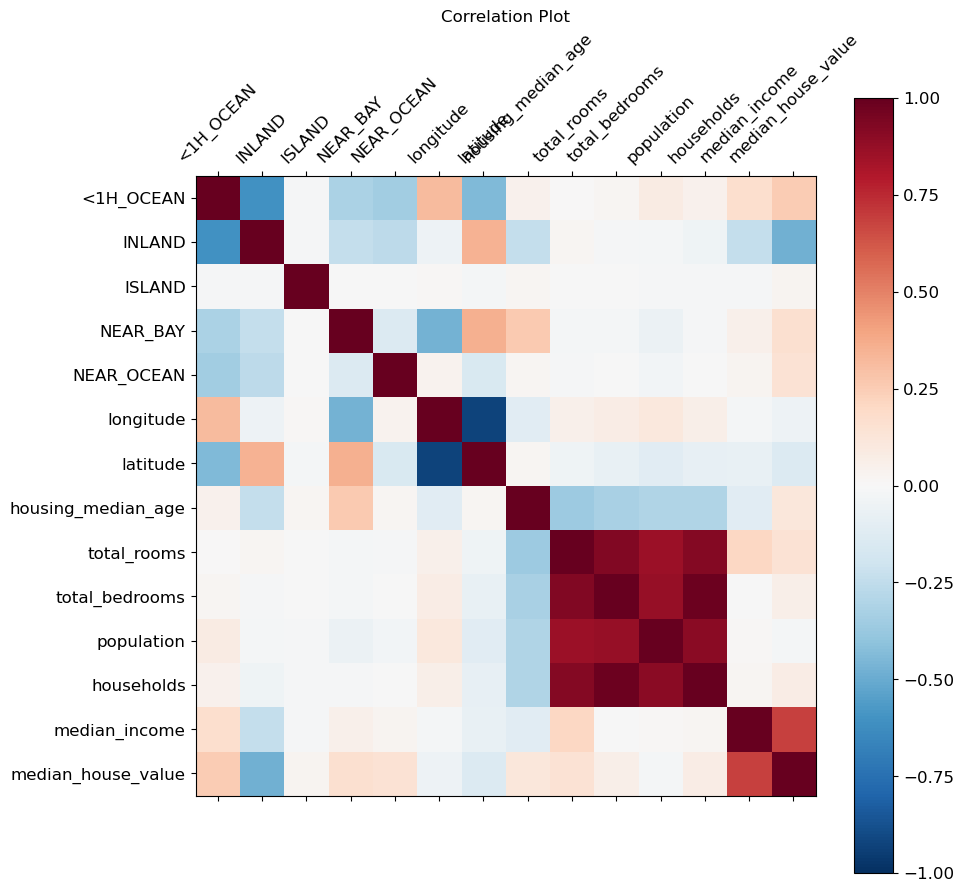

In [8]:
corr_matrix = housing_prepped.corr()
f = plt.figure(figsize=(10,10))
plt.matshow(corr_matrix, vmin=-1, vmax=1, cmap='RdBu_r', fignum=f.number)
plt.title('Correlation Plot')
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation = 45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.show()

We observe a notable and understandable correlation between `median_income` and `median_house_value`. `INLAND` neighborhoods also tend to have lower house prices according to the plot. There is also a high degree of multicollinearity between `total_rooms`, `total_bedrooms`, `population`, `households`. In light of this we will attempt to devise a way to isolate a feature by observing its effects while normalizing the remaining features as much as possible.

In [280]:
correlation_strengths = {}

In [282]:
from sklearn.cluster import KMeans

def cluster_corr_stats(_df, target_col, feature_col, n_clusters, random_state=37):
    """
    Function to compute the mean and standard deviation of correlations between
    a chosen feature and target within KMeans clusters of other features.
    
    Parameters:
    df (pd.DataFrame): DataFrame including the target column and feature columns
    target_col (str): The target column name
    feature_col (str): The feature column name to compute correlations with the target
    n_clusters (int): Number of clusters for KMeans
    random_state (int): Random state for reproducibility
    
    Returns:
    mean_corr (float): Mean of the correlations
    std_corr (float): Standard deviation of the correlations
    """
    df = _df.copy()
    # Check if target and feature columns exist in the dataframe
    if target_col not in df.columns or feature_col not in df.columns:
        raise ValueError(f"Columns {target_col} and/or {feature_col} are not in the DataFrame")
    
    # Get the columns to use for clustering (excluding the target and chosen feature)
    clustering_columns = df.columns.difference([target_col, feature_col])
    
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    df['cluster'] = kmeans.fit_predict(df[clustering_columns])
    
    # Compute correlations within each cluster
    correlations = []
    for cluster in df['cluster'].unique():
        cluster_data = df[df['cluster'] == cluster]
        if len(cluster_data) >=  30:
            corr = cluster_data[feature_col].corr(cluster_data[target_col])
            correlations.append(corr)
    
    # Calculate mean and standard deviation of the correlations
    mean_corr = np.mean(correlations)
    std_corr = np.std(correlations)
    
    return mean_corr, std_corr
excluded_columns = ['<1H_OCEAN', 'INLAND', 'ISLAND', 'NEAR_BAY', 'NEAR_OCEAN', 'median_house_value']

for feature in housing_prepped_scaled.columns.difference(excluded_columns):
    mean_corr, std_corr = cluster_corr_stats(housing_prepped_scaled, target_col='median_house_value', feature_col=feature, n_clusters=round(len(housing_prepped_scaled)/30))
    correlation_strengths[feature] = {'mean_corr': mean_corr, 'std_corr': std_corr}
    print(f"{feature} Mean Correlation: {mean_corr}", f"Standard Deviation: {std_corr}")

households Mean Correlation: 0.11283319743925103 Standard Deviation: 0.23102099729449355
housing_median_age Mean Correlation: 0.0734878769371149 Standard Deviation: 0.29444796139327434
latitude Mean Correlation: -0.01884540962820805 Standard Deviation: 0.29936746440718426
longitude Mean Correlation: -0.1930544498617128 Standard Deviation: 0.2535010908350526
median_income Mean Correlation: 0.6466047977216863 Standard Deviation: 0.16666165052543075
population Mean Correlation: -0.29084581301399276 Standard Deviation: 0.2088979294154584
total_bedrooms Mean Correlation: 0.15978196164155317 Standard Deviation: 0.20923843175289766
total_rooms Mean Correlation: 0.11850722951067806 Standard Deviation: 0.2222632427836664


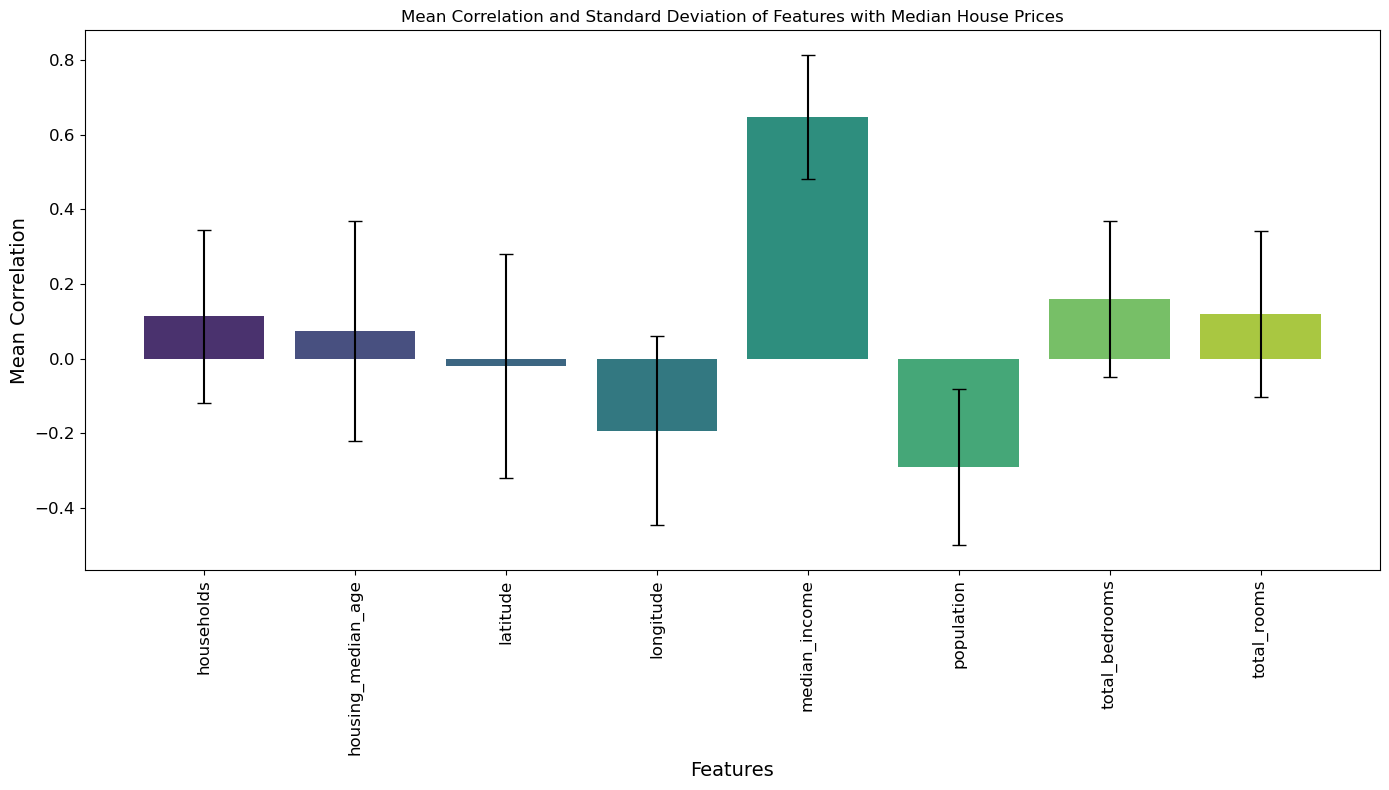

In [284]:
plt.figure(figsize=(14, 8))
corr_df = pd.DataFrame(correlation_strengths).T
corr_df.reset_index(inplace=True)
corr_df.columns = ['feature', 'mean_corr', 'std_corr']
# Create bar plot for mean correlations
sns.barplot(data=corr_df, x='feature', y='mean_corr', palette='viridis')

# Add error bars for standard deviation
for i in range(corr_df.shape[0]):
    plt.errorbar(i, corr_df['mean_corr'][i], yerr=corr_df['std_corr'][i], fmt='none', c='black', capsize=5)

# Customize the plot
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Mean Correlation')
plt.title('Mean Correlation and Standard Deviation of Features with Median House Prices')
plt.tight_layout()

# Show the plot
plt.show()


A notable observation is that all else equal (as equal as possible), higher population is somewhat correlated to lower housing prices. Let us now inspect how informative ratios between these features are using a similar mechanism.

In [287]:
def cluster_corr_stats_ratio(_std_df, _unstd_df, target_col, feature_col1, feature_col2, n_clusters=3, random_state=37):
    """
    Function to compute the mean and standard deviation of correlations between
    the ratio of two chosen features and the target within KMeans clusters of other features.
    
    Parameters:
    std_df (pd.DataFrame): Standardized DataFrame including the target column and feature columns
    unstd_df (pd.DataFrame): Unstandardized DataFrame for computing the feature ratio
    target_col (str): The target column name
    feature_col1 (str): The first feature column name to compute the ratio
    feature_col2 (str): The second feature column name to compute the ratio
    n_clusters (int): Number of clusters for KMeans
    random_state (int): Random state for reproducibility
    
    Returns:
    mean_corr (float): Mean of the correlations
    std_corr (float): Standard deviation of the correlations
    """
    std_df = _std_df.copy() 
    unstd_df = _unstd_df.copy() 
    # Check if target and feature columns exist in both dataframes
    if target_col not in std_df.columns or feature_col1 not in std_df.columns or feature_col2 not in std_df.columns:
        raise ValueError(f"Columns {target_col}, {feature_col1}, and/or {feature_col2} are not in the DataFrame")
    
    # Compute the ratio using the unstandardized dataframe
    unstd_df['ratio'] = unstd_df[feature_col1] / unstd_df[feature_col2]
    
    # Standardize the ratio
    scaler = StandardScaler()
    std_df['ratio'] = scaler.fit_transform(unstd_df[['ratio']])

    for feature in [feature_col1, feature_col2]: 
        # Get the columns to use for clustering (excluding the target and chosen features)
        clustering_columns = std_df.columns.difference([target_col, 'ratio'])
        
        # Apply KMeans clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
        std_df['cluster'] = kmeans.fit_predict(std_df[clustering_columns])
        
        # Compute correlations within each cluster
        correlations = []
        for cluster in std_df['cluster'].unique():  
            cluster_data = std_df[std_df['cluster'] == cluster]
            if len(cluster_data) >= 30:
                corr = cluster_data['ratio'].corr(cluster_data[target_col])
                correlations.append(corr)
        
        # Calculate mean and standard deviation of the correlations
    mean_corr = np.mean(correlations)
    std_corr = np.std(correlations)
    
    return mean_corr, std_corr


for f1 in housing_prepped_scaled.columns.difference(excluded_columns+['latitude', 'longitude']):
    for f2 in housing_prepped_scaled.columns.difference(excluded_columns+['latitude', 'longitude']):
        if f1 != f2:
            mean_corr, std_corr = cluster_corr_stats_ratio(housing_prepped_scaled, housing_prepped, target_col='median_house_value', feature_col1=f1, feature_col2=f2, n_clusters=round(len(housing_prepped)/30))
            print(f"{f1}/{f2} Mean Correlation: {mean_corr}, Standard Deviation: {std_corr}")
            correlation_strengths[f"{f1}/{f2}"] = {'mean_corr': mean_corr, 'std_corr': std_corr}


households/housing_median_age Mean Correlation: 0.06235034980386612, Standard Deviation: 0.21719423612299302
households/median_income Mean Correlation: -0.11236911345563315, Standard Deviation: 0.21649792747371022
households/population Mean Correlation: 0.34773169052206676, Standard Deviation: 0.26348528631610396
households/total_bedrooms Mean Correlation: -0.08481885407666788, Standard Deviation: 0.20099825171322286
households/total_rooms Mean Correlation: -0.04982463666404504, Standard Deviation: 0.27487234135431016
housing_median_age/households Mean Correlation: -0.048014780489599465, Standard Deviation: 0.22654547189422447
housing_median_age/median_income Mean Correlation: -0.17987411712959303, Standard Deviation: 0.19515317570087745
housing_median_age/population Mean Correlation: 0.23288622018099336, Standard Deviation: 0.2520483682444886
housing_median_age/total_bedrooms Mean Correlation: -0.07945419401434194, Standard Deviation: 0.2144851665631076
housing_median_age/total_rooms 

In [291]:
correlation_strengths = pd.DataFrame(correlation_strengths).T
correlation_strengths.reindex(correlation_strengths['mean_corr'].abs().sort_values(ascending=False).index)

,mean_corr,std_corr
median_income,0.646605,0.166662
median_income/population,0.353081,0.228213
population/median_income,-0.350838,0.200695
households/population,0.347732,0.263485
total_rooms/population,0.342764,0.261473
total_bedrooms/population,0.341668,0.264838
population/total_bedrooms,-0.314014,0.251156
population/households,-0.311375,0.254656
population/total_rooms,-0.307220,0.254776
population,-0.290846,0.208898


Notably, ratios between population and other features have stronger correlations than population on its own. Let us now add these ratios to our data set.

In [165]:
ratios = pd.DataFrame()
for f1 in housing_prepped_scaled.columns.difference(excluded_columns+['latitude', 'longitude']):
    for f2 in housing_prepped_scaled.columns.difference(excluded_columns+['latitude', 'longitude']):
        if f1 != f2:
            ratios[f"{f1}/{f2}"] = housing_prepped[f1] / housing_prepped[f2]


ratio_scaler = StandardScaler()
ratios_scaled = pd.DataFrame(ratio_scaler.fit_transform(ratios), columns=ratios.columns)
housing_prepped_scaled_with_ratios = pd.concat([housing_prepped_scaled, ratios_scaled], axis=1)
housing_prepped_scaled_with_ratios

,<1H_OCEAN,INLAND,ISLAND,NEAR_BAY,NEAR_OCEAN,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,...,total_bedrooms/households,total_bedrooms/housing_median_age,total_bedrooms/median_income,total_bedrooms/population,total_bedrooms/total_rooms,total_rooms/households,total_rooms/housing_median_age,total_rooms/median_income,total_rooms/population,total_rooms/total_bedrooms
0,1.0,0.0,0.0,0.0,0.0,-1.026184,0.492694,-0.367613,-0.024450,0.473891,...,-0.089477,-0.019557,1.096876,-0.703558,1.250315,-0.690472,-0.143339,0.691454,-1.014008,-0.900261
1,0.0,1.0,0.0,0.0,0.0,-1.255168,2.663430,1.856594,0.628425,0.675405,...,0.142858,-0.237702,1.273290,0.295322,-0.135995,0.102682,-0.220410,1.673378,0.298341,-0.071358
2,1.0,0.0,0.0,0.0,0.0,0.850486,-0.854659,0.426747,-0.389292,-0.140134,...,-0.016936,-0.262931,0.002300,-0.499470,0.947607,-0.541935,-0.282111,-0.219153,-0.805766,-0.761645
3,1.0,0.0,0.0,0.0,0.0,0.850486,-0.896763,0.585619,-1.121719,-1.178523,...,0.077880,-0.451964,-1.015043,-0.807678,0.121054,-0.107507,-0.401300,-1.167594,-0.911453,-0.270710
4,0.0,1.0,0.0,0.0,0.0,-0.846980,1.161692,-1.400280,0.237066,0.604283,...,-0.111225,0.584576,0.998727,-0.105206,0.659249,-0.508192,0.307955,0.858013,-0.409818,-0.611614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,0.0,1.0,0.0,0.0,0.0,1.104359,-0.779806,-0.288177,-0.113603,-0.528937,...,-0.183556,-0.284499,-0.847790,-0.284685,-1.400389,0.870552,-0.173791,-0.783639,0.464779,1.563587
16508,1.0,0.0,0.0,0.0,0.0,0.671281,-0.695596,1.856594,-0.574456,-0.635621,...,0.075354,-0.392925,-0.627575,-0.138548,-0.305086,0.148208,-0.347556,-0.651934,-0.077587,0.076336
16509,0.0,1.0,0.0,0.0,0.0,-1.140676,0.969882,-1.241408,3.189634,1.908197,...,-0.265090,1.040013,0.203206,-0.389244,-1.265410,0.587657,1.445143,1.100222,0.183391,1.307424
16510,0.0,1.0,0.0,0.0,0.0,0.890309,-0.489751,-1.797459,3.483153,3.140988,...,-0.101869,4.065509,2.006372,-0.404369,-0.540568,0.130362,3.883766,3.076366,-0.269408,0.308523


We are now ready to define our features and target.

In [136]:
features = housing_prepped_scaled_with_ratios.drop("median_house_value", axis=1)
target = housing_prepped["median_house_value"]

## Training and Validation
We'll now train and validate a variety of models to find the best performing one.
The models we'll train are:
- SGD
- LinearSV
- KNeighbors
- DecisionTree
- Tree Ensembles
    - ExtraTrees 
    - RandomForest
- Boosting Ensembles
    - AdaBoost
    - GradientBoosting
    - XGBoost



We'll utilize the optuna library to tune these models.

In [292]:
import optuna

from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, root_mean_squared_error
sampler = optuna.samplers.TPESampler(seed=37)
kfold = KFold(n_splits=10, shuffle=True, random_state=37)
rmse_scorer = make_scorer(root_mean_squared_error)
best_scores = {}
tuning_times = {}

In [24]:
from sklearn.linear_model import SGDRegressor

def sgd_objective(trial):
    loss = trial.suggest_categorical('sgd_loss', ['squared_error', 'huber', 'epsilon_insensitive'])
    alpha = trial.suggest_float('sgd_alpha', 1e-10, 1e-2, log=True)
    learning_rate = trial.suggest_categorical('sgd_learning_rate', ['invscaling', 'constant']) 
    fit_intercept = trial.suggest_categorical('sgd_fit_intercept', [True, False])
    l1_ratio = trial.suggest_float('sgd_l1_ratio', 0, 1)
    eta0 = trial.suggest_float('sgd_eta0', 1e-2, 1, log=True)
    if learning_rate == 'invscaling':     
        power_t = trial.suggest_float('sgd_power_t', 1e-10, 100, log=True)
        reg = SGDRegressor(penalty='elasticnet', loss=loss, alpha=alpha, learning_rate=learning_rate, fit_intercept=fit_intercept, l1_ratio=l1_ratio, eta0=eta0, power_t=power_t, random_state=37)
    else:
        reg = SGDRegressor(penalty='elasticnet', loss=loss, alpha=alpha, learning_rate=learning_rate, fit_intercept=fit_intercept, l1_ratio=l1_ratio, eta0=eta0, random_state=37) 
    return cross_val_score(reg, features, target, cv=kfold, scoring=rmse_scorer, n_jobs=-1).mean()

sgd_study = optuna.create_study(direction='minimize', sampler=sampler)
sgd_study.optimize(sgd_objective, n_trials=50)

[I 2024-06-18 23:25:38,013] A new study created in memory with name: no-name-911d005f-f96a-44be-ba1f-601b4def3220
[I 2024-06-18 23:25:38,426] Trial 0 finished with value: 35101238340900.99 and parameters: {'sgd_loss': 'squared_error', 'sgd_alpha': 0.003949561456226272, 'sgd_learning_rate': 'invscaling', 'sgd_fit_intercept': False, 'sgd_l1_ratio': 0.8249653339063518, 'sgd_eta0': 0.7647662529990713, 'sgd_power_t': 0.01869766591680054}. Best is trial 0 with value: 35101238340900.99.
[I 2024-06-18 23:25:38,760] Trial 1 finished with value: 54225291821803.08 and parameters: {'sgd_loss': 'squared_error', 'sgd_alpha': 8.047024972622072e-10, 'sgd_learning_rate': 'constant', 'sgd_fit_intercept': False, 'sgd_l1_ratio': 0.9947793097751872, 'sgd_eta0': 0.8108697921328137}. Best is trial 0 with value: 35101238340900.99.
[I 2024-06-18 23:25:47,285] Trial 2 finished with value: 214343.24156009173 and parameters: {'sgd_loss': 'huber', 'sgd_alpha': 3.784361957433841e-08, 'sgd_learning_rate': 'constant'

In [21]:
from sklearn.svm import LinearSVR
def sv_objective(trial):
    loss = trial.suggest_categorical('sv_loss', ["epsilon_insensitive", "squared_epsilon_insensitive"])
    if loss == "squared_epsilon_insensitive":
        dual = trial.suggest_categorical('sv_dual', [True, False])
    else:
        dual = True
    tol = trial.suggest_float('sv_tol', 1e-5, 1e-1, log=True)
    C = trial.suggest_float('sv_C', 1e-4, 25, log=True)
    epsilon = trial.suggest_float('sv_epsilon', 1e-4, 1, log=True)
    reg = LinearSVR(loss=loss, dual=dual, tol=tol, C=C, epsilon=epsilon, random_state=37)
    return cross_val_score(reg, features, target, cv=kfold, scoring=rmse_scorer, n_jobs=-1).mean()

sv_study = optuna.create_study(direction='minimize', sampler=sampler)
sv_study.optimize(sv_objective, n_trials=50)

[I 2024-06-18 22:27:41,901] A new study created in memory with name: no-name-aaa936f2-ca73-4efb-9bca-f3f3acd30b41
[I 2024-06-18 22:27:42,120] Trial 0 finished with value: 237336.70407975558 and parameters: {'sv_loss': 'epsilon_insensitive', 'sv_tol': 2.482486772302544e-05, 'sv_C': 0.0022212199901820327, 'sv_epsilon': 0.08964909826653196}. Best is trial 0 with value: 237336.70407975558.
[I 2024-06-18 22:27:42,344] Trial 1 finished with value: 236365.0249188769 and parameters: {'sv_loss': 'epsilon_insensitive', 'sv_tol': 9.41649267313922e-05, 'sv_C': 0.05890415757781529, 'sv_epsilon': 0.0007550178746967155}. Best is trial 1 with value: 236365.0249188769.
[I 2024-06-18 22:27:42,605] Trial 2 finished with value: 123996.46769077622 and parameters: {'sv_loss': 'epsilon_insensitive', 'sv_tol': 2.509365530497874e-05, 'sv_C': 8.851843549224538, 'sv_epsilon': 0.00012866603666493245}. Best is trial 2 with value: 123996.46769077622.
[I 2024-06-18 22:27:42,823] Trial 3 finished with value: 236071.0

In [20]:
from sklearn.neighbors import KNeighborsRegressor
def knn_objective(trial):
    n_neighbors = trial.suggest_int('knn_n_neighbors', 1, 100)
    weights = trial.suggest_categorical('knn_weights', ['uniform', 'distance'])
    p = trial.suggest_categorical('knn_p', [1, 2])
    reg = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, p=p)
    return cross_val_score(reg, features, target, cv=kfold, scoring=rmse_scorer, n_jobs=-1).mean()

knn_study = optuna.create_study(direction='minimize', sampler=sampler)
knn_study.optimize(knn_objective, n_trials=50)

[I 2024-06-18 22:26:45,314] A new study created in memory with name: no-name-5e2da46e-7840-4375-b7aa-71ecbb5d2bbf
[I 2024-06-18 22:26:46,287] Trial 0 finished with value: 58325.514129669566 and parameters: {'knn_n_neighbors': 15, 'knn_weights': 'distance', 'knn_p': 2}. Best is trial 0 with value: 58325.514129669566.
[I 2024-06-18 22:26:48,161] Trial 1 finished with value: 62367.93799606691 and parameters: {'knn_n_neighbors': 96, 'knn_weights': 'distance', 'knn_p': 1}. Best is trial 0 with value: 58325.514129669566.
[I 2024-06-18 22:26:49,008] Trial 2 finished with value: 62864.90666247501 and parameters: {'knn_n_neighbors': 91, 'knn_weights': 'uniform', 'knn_p': 2}. Best is trial 0 with value: 58325.514129669566.
[I 2024-06-18 22:26:49,558] Trial 3 finished with value: 58633.85933791221 and parameters: {'knn_n_neighbors': 12, 'knn_weights': 'uniform', 'knn_p': 2}. Best is trial 0 with value: 58325.514129669566.
[I 2024-06-18 22:26:50,175] Trial 4 finished with value: 62805.21592121349 

In [19]:
from sklearn.tree import DecisionTreeRegressor
def dt_objective(trial):
    max_depth = trial.suggest_int('dt_max_depth', 1, 20)
    min_samples_split = trial.suggest_int('dt_min_samples_split', 2, 40)
    min_samples_leaf = trial.suggest_int('dt_min_samples_leaf', 1, 40)
    reg = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=37)
    return cross_val_score(reg, features, target, cv=kfold, scoring=rmse_scorer, n_jobs=-1).mean()

dt_study = optuna.create_study(direction='minimize', sampler=sampler)
dt_study.optimize(dt_objective, n_trials=50)

[I 2024-06-18 22:26:01,274] A new study created in memory with name: no-name-776462be-a567-477f-81b5-d0ebf04540bd
[I 2024-06-18 22:26:01,927] Trial 0 finished with value: 68544.88308115915 and parameters: {'dt_max_depth': 5, 'dt_min_samples_split': 14, 'dt_min_samples_leaf': 1}. Best is trial 0 with value: 68544.88308115915.
[I 2024-06-18 22:26:02,954] Trial 1 finished with value: 61635.998505834934 and parameters: {'dt_max_depth': 10, 'dt_min_samples_split': 4, 'dt_min_samples_leaf': 6}. Best is trial 1 with value: 61635.998505834934.
[I 2024-06-18 22:26:03,229] Trial 2 finished with value: 96478.53563940965 and parameters: {'dt_max_depth': 1, 'dt_min_samples_split': 9, 'dt_min_samples_leaf': 7}. Best is trial 1 with value: 61635.998505834934.
[I 2024-06-18 22:26:04,122] Trial 3 finished with value: 62046.30385656496 and parameters: {'dt_max_depth': 8, 'dt_min_samples_split': 10, 'dt_min_samples_leaf': 16}. Best is trial 1 with value: 61635.998505834934.
[I 2024-06-18 22:26:04,931] Tr

In [16]:
from sklearn.ensemble import ExtraTreesRegressor

def et_objective(trial):
    max_features = trial.suggest_int('et_max_features', 1, 44)
    min_samples_split = trial.suggest_int('et_min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('et_min_samples_leaf', 1, 20)
    bootstrap = trial.suggest_categorical('et_bootstrap', [True, False])
    reg = ExtraTreesRegressor(max_features=max_features, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, random_state=37)
    return cross_val_score(reg, features, target, cv=kfold, scoring=rmse_scorer, n_jobs=-1).mean()

et_study = optuna.create_study(direction='minimize', sampler=sampler)
et_study.optimize(et_objective, n_trials=50)

[I 2024-06-18 21:21:24,479] A new study created in memory with name: no-name-2a33e295-5a82-41e9-bfb5-25f989ed9ea8
[I 2024-06-18 21:21:41,861] Trial 0 finished with value: 53252.43627406591 and parameters: {'et_max_features': 42, 'et_min_samples_split': 10, 'et_min_samples_leaf': 4, 'et_bootstrap': False}. Best is trial 0 with value: 53252.43627406591.
[I 2024-06-18 21:21:51,983] Trial 1 finished with value: 55650.71475172441 and parameters: {'et_max_features': 31, 'et_min_samples_split': 3, 'et_min_samples_leaf': 15, 'et_bootstrap': False}. Best is trial 0 with value: 53252.43627406591.
[I 2024-06-18 21:21:57,802] Trial 2 finished with value: 55515.989910530545 and parameters: {'et_max_features': 35, 'et_min_samples_split': 13, 'et_min_samples_leaf': 9, 'et_bootstrap': True}. Best is trial 0 with value: 53252.43627406591.
[I 2024-06-18 21:22:00,850] Trial 3 finished with value: 58720.12712049944 and parameters: {'et_max_features': 9, 'et_min_samples_split': 13, 'et_min_samples_leaf': 1

In [22]:
from sklearn.ensemble import RandomForestRegressor

def rf_objective(trial):
    max_features = trial.suggest_int('rf_max_features', 1, 44)
    min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 1, 20)
    bootstrap = trial.suggest_categorical('rf_bootstrap', [True, False])
    reg = RandomForestRegressor(max_features=max_features, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, random_state=37)
    return cross_val_score(reg, features, target, cv=kfold, scoring=rmse_scorer, n_jobs=-1).mean()

rf_study = optuna.create_study(direction='minimize', sampler=sampler)
rf_study.optimize(rf_objective, n_trials=50)

[I 2024-06-18 22:28:52,907] A new study created in memory with name: no-name-b58df807-2974-4402-80b8-e016d50cf49e
[I 2024-06-18 22:29:12,462] Trial 0 finished with value: 53724.1394349369 and parameters: {'rf_max_features': 14, 'rf_min_samples_split': 2, 'rf_min_samples_leaf': 13, 'rf_bootstrap': True}. Best is trial 0 with value: 53724.1394349369.
[I 2024-06-18 22:29:38,741] Trial 1 finished with value: 52044.859566552244 and parameters: {'rf_max_features': 14, 'rf_min_samples_split': 3, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 1 with value: 52044.859566552244.
[I 2024-06-18 22:31:33,984] Trial 2 finished with value: 65891.72525442786 and parameters: {'rf_max_features': 44, 'rf_min_samples_split': 5, 'rf_min_samples_leaf': 4, 'rf_bootstrap': False}. Best is trial 1 with value: 52044.859566552244.
[I 2024-06-18 22:32:54,461] Trial 3 finished with value: 52674.5387689907 and parameters: {'rf_max_features': 35, 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 9, 'r

In [18]:
from sklearn.ensemble import AdaBoostRegressor
def ada_objective(trial):
    learning_rate = trial.suggest_float('ada_learning_rate', 1e-3, 1, log=True) 
    loss = trial.suggest_categorical('ada_loss', ['linear', 'square', 'exponential'])
    reg = AdaBoostRegressor(learning_rate=learning_rate, loss=loss, n_estimators=100, random_state=37)
    return cross_val_score(reg, features, target, cv=kfold, scoring=rmse_scorer, n_jobs=-1).mean()

ada_study = optuna.create_study(direction='minimize', sampler=sampler)
ada_study.optimize(ada_objective, n_trials=50)

[I 2024-06-18 22:04:28,725] A new study created in memory with name: no-name-e25a6e02-83ac-473c-ab18-d8799b853a9c
[I 2024-06-18 22:04:51,927] Trial 0 finished with value: 75977.82152241176 and parameters: {'ada_learning_rate': 0.2063030470692768, 'ada_loss': 'linear'}. Best is trial 0 with value: 75977.82152241176.
[I 2024-06-18 22:05:19,646] Trial 1 finished with value: 73408.26137369068 and parameters: {'ada_learning_rate': 0.005557006018965275, 'ada_loss': 'exponential'}. Best is trial 1 with value: 73408.26137369068.
[I 2024-06-18 22:05:46,664] Trial 2 finished with value: 70963.5634442226 and parameters: {'ada_learning_rate': 0.03621547858752981, 'ada_loss': 'square'}. Best is trial 2 with value: 70963.5634442226.
[I 2024-06-18 22:06:12,248] Trial 3 finished with value: 70980.96637162985 and parameters: {'ada_learning_rate': 0.0897699624259299, 'ada_loss': 'linear'}. Best is trial 2 with value: 70963.5634442226.
[I 2024-06-18 22:06:37,946] Trial 4 finished with value: 70267.609951

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
def gb_objective(trial):
    loss = trial.suggest_categorical('gb_loss', ['squared_error', 'absolute_error', 'huber', 'quantile'])
    learning_rate = trial.suggest_float('gb_learning_rate', 1e-3, 1, log=True) 
    max_depth = trial.suggest_int('gb_max_depth', 1, 10)
    min_samples_split = trial.suggest_int('gb_min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('gb_min_samples_leaf', 1, 20)
    subsample = trial.suggest_float('gb_subsample', 0.05, 1)
    max_features = trial.suggest_int('gb_max_features', 1, 44)
    if loss == 'huber' or loss == 'quantile':
        alpha = trial.suggest_float('gb_alpha', 0.75, .99)
        reg = GradientBoostingRegressor(loss=loss, learning_rate=learning_rate, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, subsample=subsample, max_features=max_features, alpha=alpha, random_state=37)
    else:
        reg = GradientBoostingRegressor(loss=loss, learning_rate=learning_rate, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, subsample=subsample, max_features=max_features, random_state=37)
    return cross_val_score(reg, features, target, cv=kfold, scoring=rmse_scorer, n_jobs=-1).mean()

gb_study = optuna.create_study(direction='minimize', sampler=sampler)
gb_study.optimize(gb_objective, n_trials=50)

[I 2024-06-18 21:27:02,953] A new study created in memory with name: no-name-1bef137e-5a1b-418a-a664-e38f59d7d79e
[I 2024-06-18 21:27:14,753] Trial 0 finished with value: 111166.84399139555 and parameters: {'gb_loss': 'quantile', 'learning_rate': 0.853402128921368, 'gb_max_depth': 6, 'gb_min_samples_split': 20, 'gb_min_samples_leaf': 12, 'gb_subsample': 0.3647837681284162, 'gb_max_features': 21, 'gb_alpha': 0.8563613491327435}. Best is trial 0 with value: 111166.84399139555.
[I 2024-06-18 21:27:45,714] Trial 1 finished with value: 49448.31308211594 and parameters: {'gb_loss': 'huber', 'learning_rate': 0.11810180893631343, 'gb_max_depth': 5, 'gb_min_samples_split': 5, 'gb_min_samples_leaf': 1, 'gb_subsample': 0.6176446498771904, 'gb_max_features': 42, 'gb_alpha': 0.9817202016812354}. Best is trial 1 with value: 49448.31308211594.
[I 2024-06-18 21:27:50,449] Trial 2 finished with value: 61953.35326889482 and parameters: {'gb_loss': 'absolute_error', 'learning_rate': 0.8122647028848766, '

In [23]:
from xgboost import XGBRegressor
def xgb_objective(trial):
    max_depth = trial.suggest_int('xgb_max_depth', 1, 10)
    learning_rate = trial.suggest_float('xgb_learning_rate', 1e-3, 1, log=True) 
    subsample = trial.suggest_float('xgb_subsample', 0.05, 1)
    min_child_weight = trial.suggest_int('xgb_min_child_weight', 1, 20)
    reg = XGBRegressor(max_depth=max_depth, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight, random_state=37)
    return cross_val_score(reg, np.array(features), target, cv=kfold, scoring=rmse_scorer, n_jobs=-1).mean()

xgb_study = optuna.create_study(direction='minimize', sampler=sampler)
xgb_study.optimize(xgb_objective, n_trials=50)

[I 2024-06-18 23:21:59,877] A new study created in memory with name: no-name-2f00d2ad-5729-4ec6-bb8c-ffdde1a91f41
[I 2024-06-18 23:22:01,212] Trial 0 finished with value: 101705.32911316237 and parameters: {'xgb_max_depth': 3, 'xgb_learning_rate': 0.0024692150723057745, 'xgb_subsample': 0.9392775036820246, 'xgb_min_child_weight': 19}. Best is trial 0 with value: 101705.32911316237.
[I 2024-06-18 23:22:02,991] Trial 1 finished with value: 55819.297948964595 and parameters: {'xgb_max_depth': 5, 'xgb_learning_rate': 0.3047329888215295, 'xgb_subsample': 0.17990697720362603, 'xgb_min_child_weight': 9}. Best is trial 1 with value: 55819.297948964595.
[I 2024-06-18 23:22:06,035] Trial 2 finished with value: 74288.06759910022 and parameters: {'xgb_max_depth': 6, 'xgb_learning_rate': 0.00820201292783399, 'xgb_subsample': 0.5073749554679022, 'xgb_min_child_weight': 11}. Best is trial 1 with value: 55819.297948964595.
[I 2024-06-18 23:22:06,922] Trial 3 finished with value: 102294.38652962766 and

In [319]:
name = 'SGDRegressor'
best_scores[name] = sgd_study.best_value
tuning_times[name] = sgd_study.trials_dataframe().duration.sum().total_seconds() / 60
print(name, "Min RMSE:", sgd_study.best_value, "Tuning Time (min):", sgd_study.trials_dataframe().duration.sum().total_seconds() / 60)
print(sgd_study.best_params)
print()

name = 'LinearSVR'
best_scores[name] = sv_study.best_value
tuning_times[name] = sv_study.trials_dataframe().duration.sum().total_seconds() / 60
print(name, "Min RMSE:", sv_study.best_value, "Tuning Time (min):", sv_study.trials_dataframe().duration.sum().total_seconds() / 60)
print(sv_study.best_params)
print()

name = 'KNeighborsRegressor'
best_scores[name] = knn_study.best_value
tuning_times[name] = knn_study.trials_dataframe().duration.sum().total_seconds() / 60
print(name, "Min RMSE:", knn_study.best_value, "Tuning Time (min):", knn_study.trials_dataframe().duration.sum().total_seconds() / 60)
print(knn_study.best_params)
print()

name = 'DecisionTreeRegressor'
best_scores[name] = dt_study.best_value
tuning_times[name] = dt_study.trials_dataframe().duration.sum().total_seconds() / 60
print(name, "Min RMSE:", dt_study.best_value, "Tuning Time (min):", dt_study.trials_dataframe().duration.sum().total_seconds() / 60)
print(dt_study.best_params)
print()

name = 'ExtraTreesRegressor'
best_scores[name] = et_study.best_value
tuning_times[name] = et_study.trials_dataframe().duration.sum().total_seconds() / 60
print(name, "Min RMSE:", et_study.best_value, "Tuning Time (min):", et_study.trials_dataframe().duration.sum().total_seconds() / 60)
print(et_study.best_params)
print()

name = 'RandomForestRegressor'
best_scores[name] = rf_study.best_value
tuning_times[name] = rf_study.trials_dataframe().duration.sum().total_seconds() / 60
print(name, "Min RMSE:", rf_study.best_value, "Tuning Time (min):", rf_study.trials_dataframe().duration.sum().total_seconds() / 60)
print(rf_study.best_params)
print()

name = 'AdaBoostRegressor'
best_scores[name] = ada_study.best_value
tuning_times[name] = ada_study.trials_dataframe().duration.sum().total_seconds() / 60
print(name, "Min RMSE:", ada_study.best_value, "Tuning Time (min):", ada_study.trials_dataframe().duration.sum().total_seconds() / 60)
print(ada_study.best_params)
print()
      
name = 'GradientBoostingRegressor'
best_scores[name] = gb_study.best_value
tuning_times[name] = gb_study.trials_dataframe().duration.sum().total_seconds() / 60
print(name, "Min RMSE:", gb_study.best_value, "Tuning Time (min):", gb_study.trials_dataframe().duration.sum().total_seconds() / 60)
print(gb_study.best_params)
print()
      
name = 'XGBRegressor'
best_scores[name] = xgb_study.best_value
tuning_times[name] = xgb_study.trials_dataframe().duration.sum().total_seconds() / 60
print(name, "Min RMSE:", xgb_study.best_value, "Tuning Time (min):", xgb_study.trials_dataframe().duration.sum().total_seconds() / 60)
print(xgb_study.best_params)

SGDRegressor Min RMSE: 66068.8731249991 Tuning Time (min): 5.4223236833333335
{'sgd_loss': 'epsilon_insensitive', 'sgd_alpha': 3.432021076161445e-09, 'sgd_learning_rate': 'constant', 'sgd_fit_intercept': True, 'sgd_l1_ratio': 0.5268450810599309, 'sgd_eta0': 0.9412603447960023}

LinearSVR Min RMSE: 64872.0538787288 Tuning Time (min): 1.1823764166666666
{'sv_loss': 'squared_epsilon_insensitive', 'sv_dual': True, 'sv_tol': 0.004172528050976176, 'sv_C': 0.007970679733240683, 'sv_epsilon': 0.8027922812703424}

KNeighborsRegressor Min RMSE: 58292.656146385605 Tuning Time (min): 0.94230155
{'knn_n_neighbors': 14, 'knn_weights': 'distance', 'knn_p': 2}

DecisionTreeRegressor Min RMSE: 60633.318988421015 Tuning Time (min): 0.7332564666666667
{'dt_max_depth': 10, 'dt_min_samples_split': 9, 'dt_min_samples_leaf': 15}

ExtraTreesRegressor Min RMSE: 52533.92125242831 Tuning Time (min): 5.640493966666667
{'et_max_features': 20, 'et_min_samples_split': 9, 'et_min_samples_leaf': 2, 'et_bootstrap': Fal

Let's visualize the RMSE of each model. Given the narrow range of RMSE values, another plot is made where we normalize the values on a 0-1 scale. We subtract those values from 1 so that the new plot shows higher-performing models with higher values, making the differences more apparent.

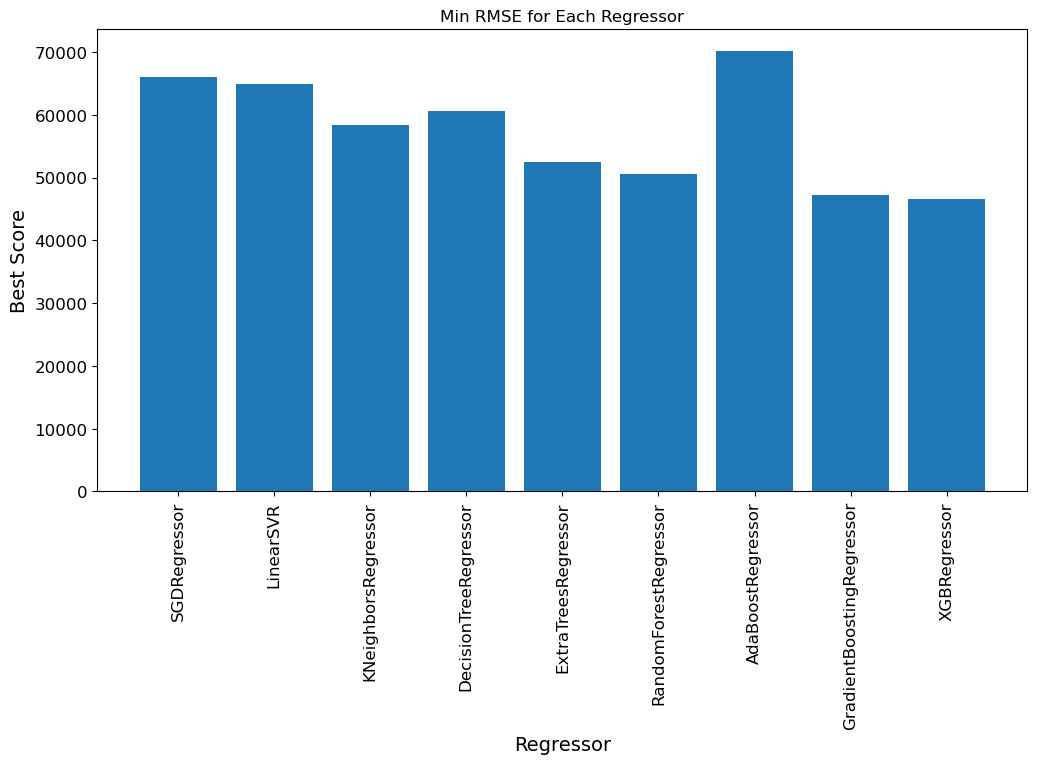

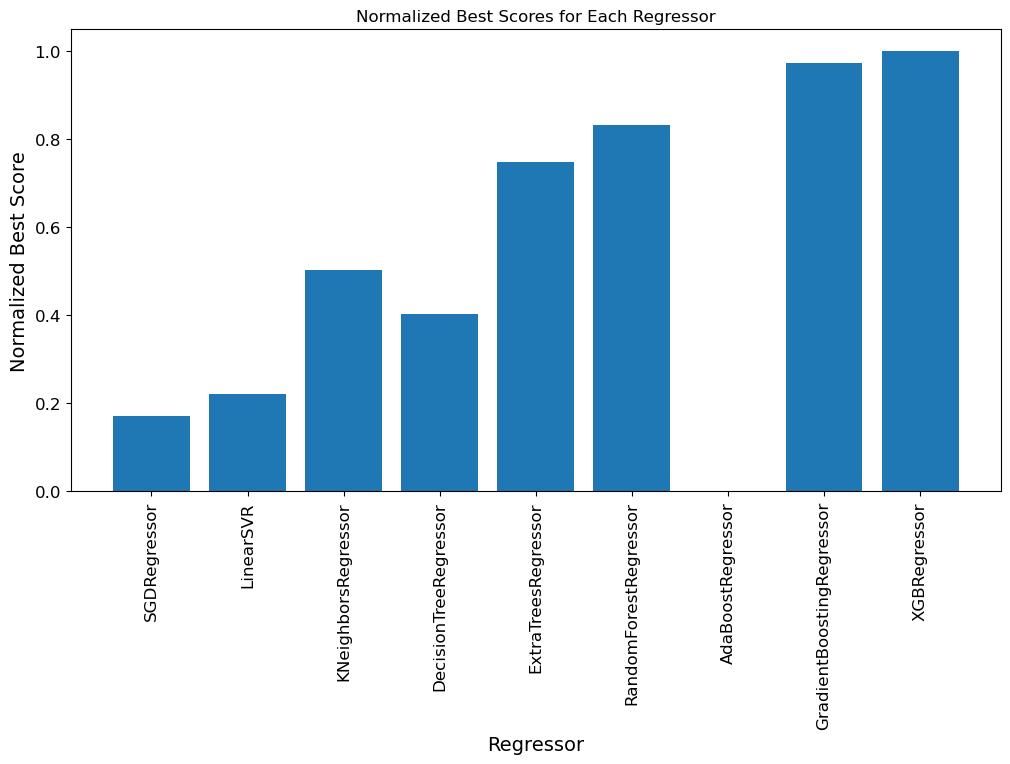

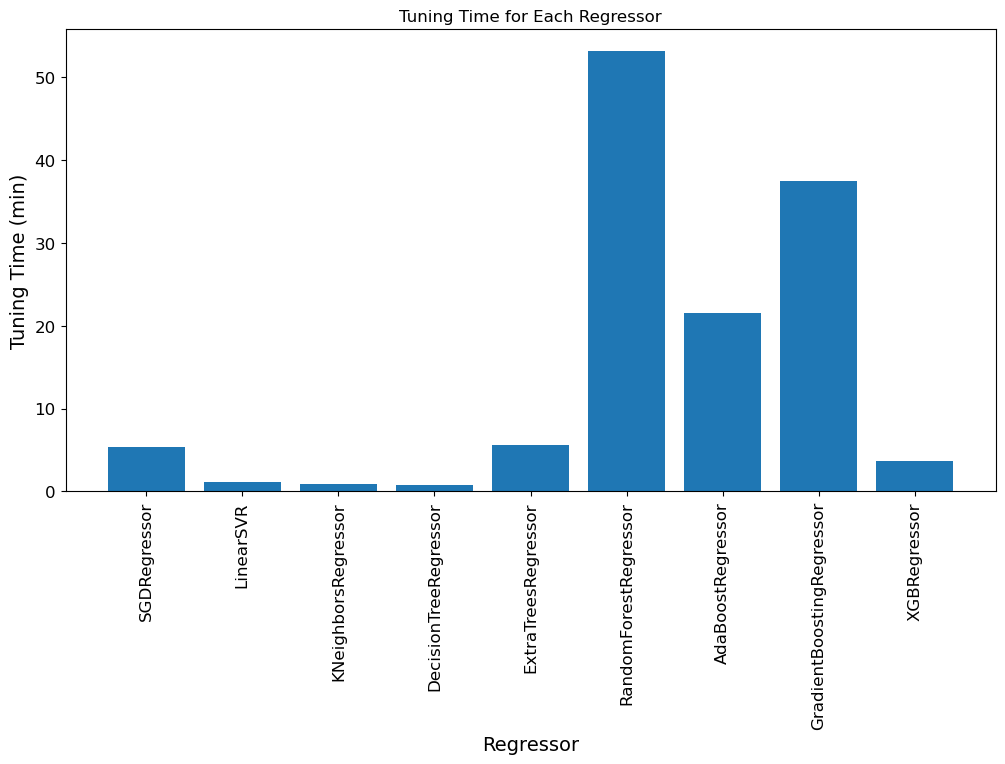

In [325]:
# Plotting the best scores
plt.figure(figsize=(12, 6))
plt.bar(best_scores.keys(), best_scores.values())
plt.xlabel('Regressor')
plt.ylabel('Best Score')
plt.title('Min RMSE for Each Regressor')
plt.xticks(rotation=90)
plt.show()

# Normalize the best scores
min_score = min(best_scores.values())
max_score = max(best_scores.values())
normalized_scores = {key: 1-(value - min_score) / (max_score - min_score) for key, value in best_scores.items()}

# Plotting the normalized best scores
plt.figure(figsize=(12, 6))
plt.bar(normalized_scores.keys(), normalized_scores.values())
plt.xlabel('Regressor')
plt.ylabel('Normalized Best Score')
plt.title('Normalized Best Scores for Each Regressor')
plt.xticks(rotation=90)
plt.show()

# Plotting the tuning times
plt.figure(figsize=(12, 6))
plt.bar(tuning_times.keys(), tuning_times.values())
plt.xlabel('Regressor')
plt.ylabel('Tuning Time (min)')
plt.title('Tuning Time for Each Regressor')
plt.xticks(rotation=90)
plt.show()

It appears that the XGBRegressor is best for our task. Let us now tweak our search by narrowing/expanding search spaces for different parameters based on the current best regressor. Begin by testing our incumbent regressor so that our new study is guaranteed to return a regressor at least as good as it.

In [63]:
def xgb_objective_new(trial):
    max_depth = trial.suggest_int('xgb_max_depth', 1, 20)
    learning_rate = trial.suggest_float('xgb_learning_rate', 0.01, 0.3, log=True) 
    subsample = trial.suggest_float('xgb_subsample', 0.9, 1)
    min_child_weight = trial.suggest_int('xgb_min_child_weight', 1, 40)
    reg = XGBRegressor(max_depth=max_depth, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight, random_state=37)
    return cross_val_score(reg, np.array(features), target, cv=kfold, scoring=rmse_scorer, n_jobs=-1).mean()

xgb_study_new = optuna.create_study(direction='minimize', sampler=sampler)
xgb_study_new.enqueue_trial(xgb_study.best_params)
xgb_study_new.optimize(xgb_objective_new, n_trials=50)
print("Old RMSE:", xgb_study.best_value, "New RMSE", xgb_study_new.best_value)

[I 2024-06-19 00:12:32,655] A new study created in memory with name: no-name-42815b16-e1e0-4449-9ddb-8535a414c9ea
[I 2024-06-19 00:12:33,297] Trial 0 finished with value: 61094.95504687967 and parameters: {'xgb_max_depth': 1, 'xgb_learning_rate': 0.2648925858672462, 'xgb_subsample': 0.9819105930514928, 'xgb_min_child_weight': 1}. Best is trial 0 with value: 61094.95504687967.
[I 2024-06-19 00:12:44,191] Trial 1 finished with value: 46637.239799272866 and parameters: {'xgb_max_depth': 19, 'xgb_learning_rate': 0.06968080579243462, 'xgb_subsample': 0.9298748417988255, 'xgb_min_child_weight': 33}. Best is trial 1 with value: 46637.239799272866.
[I 2024-06-19 00:12:49,679] Trial 2 finished with value: 47073.31519738558 and parameters: {'xgb_max_depth': 14, 'xgb_learning_rate': 0.13539607517610094, 'xgb_subsample': 0.9684537151276514, 'xgb_min_child_weight': 37}. Best is trial 1 with value: 46637.239799272866.
[I 2024-06-19 00:12:52,197] Trial 3 finished with value: 49706.29822129571 and par

We can now create a regressor with our new optimal parameters and inspect the feature importances of the model.

In [228]:
max_depth = xgb_study_new.best_params['xgb_max_depth']
learning_rate = xgb_study_new.best_params['xgb_learning_rate']
subsample = xgb_study_new.best_params['xgb_subsample']
min_child_weight = xgb_study_new.best_params['xgb_min_child_weight']

    
best_regressor = XGBRegressor(max_depth=max_depth, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight, random_state=37)
best_regressor.fit(np.array(features), target)
feature_importances = pd.DataFrame()
feature_importances['feature'] = features.columns
feature_importances['importance'] = best_regressor.feature_importances_
feature_importances.sort_values('importance', ascending=False)


,feature,importance
1,INLAND,0.359154
41,total_rooms/population,0.183473
12,median_income,0.147852
28,population/households,0.077061
15,households/population,0.017602
36,total_bedrooms/population,0.017499
42,total_rooms/total_bedrooms,0.014353
7,housing_median_age,0.014187
31,population/total_bedrooms,0.013034
32,population/total_rooms,0.011381


In accordance with our initial correlation analysis, the `INLAND` and `median_income` features were key. We also observe that population ratios are also informative commensurate with our expectations based on the increased correlation vs population alone.

`sklearn` contains multiple feature selection methods. However, given our relatively small feature set and my curiosity, we can utilize optuna to select which features to keep in the model or if dropping some may increase performance. Similar to before, we will begin by testing the model that includes all features.

In [75]:
def xgb_objective_features(trial):
    selected = {}
    for feature in features.columns:
        sel = trial.suggest_categorical(feature, [True, False])
        if sel:
            selected[feature] = True
        else:
            selected[feature] = False
    selected_features = [feature for feature in features.columns if selected[feature]]
    if selected_features:
        return cross_val_score(best_regressor, np.array(features[selected_features]), target, cv=kfold, scoring=rmse_scorer, n_jobs=-1).mean()
    else:
        return np.nan

all_features = {}
for feature in features.columns:
    all_features[feature] = True
xgb_study_features = optuna.create_study(direction='minimize', sampler=sampler)
xgb_study_features.enqueue_trial(all_features)
xgb_study_features.optimize(xgb_objective_features, n_trials=150)

[I 2024-06-19 00:39:17,928] A new study created in memory with name: no-name-a73bd5d9-2dec-41db-b8a4-dafc4bae66b4
[I 2024-06-19 00:39:28,968] Trial 0 finished with value: 46547.21051425415 and parameters: {'<1H_OCEAN': True, 'INLAND': True, 'ISLAND': True, 'NEAR_BAY': True, 'NEAR_OCEAN': True, 'longitude': True, 'latitude': True, 'housing_median_age': True, 'total_rooms': True, 'total_bedrooms': True, 'population': True, 'households': True, 'median_income': True, 'households/housing_median_age': True, 'households/median_income': True, 'households/population': True, 'households/total_bedrooms': True, 'households/total_rooms': True, 'housing_median_age/households': True, 'housing_median_age/median_income': True, 'housing_median_age/population': True, 'housing_median_age/total_bedrooms': True, 'housing_median_age/total_rooms': True, 'median_income/households': True, 'median_income/housing_median_age': True, 'median_income/population': True, 'median_income/total_bedrooms': True, 'median_in

In [151]:
dropped_features = [feature for feature in features.columns if not xgb_study_features.best_params[feature]]
new_features = features.drop(dropped_features, axis=1)
best_regressor.fit(np.array(new_features), target)
print("Dropped Features:", dropped_features)

Dropped Features: ['median_income/population', 'total_bedrooms/housing_median_age']


In [ ]:
print("Old RMSE:", xgb_study_new.best_value, "New RMSE", xgb_study_features.best_value)

Once again we observe a slight increase in performance.

## Testing
We can now test our model to see how well it performs in the "real-world".

In [160]:
from sklearn.metrics import root_mean_squared_error

housing_test_prepped = pd.DataFrame(feature_transformer.transform(test_set), columns=['<1H_OCEAN', 'INLAND', 'ISLAND', 'NEAR_BAY', 'NEAR_OCEAN']+list(numerical_col_names))
housing_test_prepped_scaled = pd.DataFrame(feature_transformer_scale.transform(test_set), columns=['<1H_OCEAN', 'INLAND', 'ISLAND', 'NEAR_BAY', 'NEAR_OCEAN']+list(numerical_col_names))
housing_test_prepped['median_house_value'] = housing_test_prepped_scaled['median_house_value'] = list(test_set.median_house_value)
ratios = pd.DataFrame()
for f1 in housing_test_prepped_scaled.columns.difference(excluded_columns+['latitude', 'longitude']):
    for f2 in housing_test_prepped_scaled.columns.difference(excluded_columns+['latitude', 'longitude']):
        if f1 != f2:
            ratios[f"{f1}/{f2}"] = housing_test_prepped[f1] / housing_test_prepped[f2]


ratios_test_scaled = pd.DataFrame(ratio_scaler.transform(ratios), columns=ratios.columns)
housing_prepped_test_scaled_with_ratios = pd.concat([housing_test_prepped_scaled, ratios_test_scaled], axis=1)

features_test = housing_prepped_test_scaled_with_ratios.drop(["median_house_value"]+dropped_features, axis=1)
target_test = housing_prepped_test_scaled_with_ratios["median_house_value"]
predictions = best_regressor.predict(features_test)
training_rmse = np.sqrt(((best_regressor.predict(new_features)-target)**2).mean())
cv_rmse = xgb_study_features.best_value
test_rmse = root_mean_squared_error(target_test, predictions)
cv_r2 = cross_val_score(best_regressor, np.array(features), target, cv=kfold, n_jobs=-1).mean()
def r2(rmse, target):
    n = len(target)
    mean = np.mean(target)
    numerator = n*rmse**2
    denominator = sum([(val-mean)**2 for val in target])
    return 1-numerator/denominator
    
print('Training RMSE', training_rmse, 'Cross-Validation RMSE:', cv_rmse,'Test RMSE:', test_rmse)
print('Training R^2', r2(training_rmse, target), 'Cross-Validation R^2:', cv_r2,'Test R^2:', r2(test_rmse, target_test))

Training RMSE 32017.24543394315 Cross-Validation RMSE: 46547.19003303456 Test RMSE: 42951.84113694304
Training R^2 0.9235428606002292 Cross-Validation R^2: 0.8381326758919952 Test R^2: 0.8574781869305114


In [164]:
test_with_predictions = test_set.copy()
test_with_predictions['predicted_median_house_value'] = predictions
test_with_predictions.insert(0, 'predicted_median_house_value', test_with_predictions.pop('predicted_median_house_value'))
test_with_predictions.insert(0, 'median_house_value', test_with_predictions.pop('median_house_value'))
test_with_predictions.iloc[:50]

,median_house_value,predicted_median_house_value,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
5132,98200.0,97772.617188,-118.26,33.98,43.0,762.0,206.0,854.0,188.0,1.2315,<1H OCEAN
13638,84000.0,114699.507812,-117.32,34.08,46.0,1308.0,276.0,576.0,244.0,3.1875,INLAND
19689,83800.0,73498.156250,-121.61,39.13,21.0,1432.0,328.0,933.0,336.0,1.6823,INLAND
8587,379300.0,406363.343750,-118.38,33.89,35.0,1778.0,330.0,732.0,312.0,6.5745,<1H OCEAN
87,162500.0,177496.687500,-122.27,37.81,10.0,875.0,348.0,546.0,330.0,0.7600,NEAR BAY
1827,220100.0,211404.609375,-122.31,37.92,38.0,1250.0,236.0,631.0,279.0,3.7240,NEAR BAY
20460,258100.0,303767.375000,-118.75,34.29,17.0,5512.0,NaN,2734.0,814.0,6.6073,<1H OCEAN
11464,262500.0,248256.140625,-117.99,33.67,17.0,1692.0,427.0,903.0,423.0,3.5859,<1H OCEAN
11807,135500.0,144790.156250,-121.10,38.92,21.0,4064.0,871.0,1847.0,859.0,3.0321,INLAND
6885,185600.0,162308.656250,-118.09,34.06,31.0,1146.0,289.0,1163.0,258.0,2.2083,<1H OCEAN


Thanks to k-fold cross validation, the test error is fairly similar to the validation error. This allows us to predict performance on unseen data, as long its distribution is reasonably similar to the training data.

## Classification
What if we're less concerned about the exact predicted price and simply wish to classify each neighborhood as `LOW`, `MEDIUM`, or `HIGH` value. To accomplish this we can simply convert our `median_house_value` column into said classifications using bins.

In [235]:
from sklearn.preprocessing import LabelEncoder
# Transform to classification task.
classes = ['LOW', 'MEDIUM', 'HIGH']
le = LabelEncoder()
house_value_class = pd.cut(pd.read_csv('housing.csv')["median_house_value"], bins=[0.0, 200000, 400000, np.inf], labels=classes)
house_value_class = pd.Series(le.fit_transform(house_value_class), index=house_value_class.index)
house_value_class_train, house_value_class_test = house_value_class.loc[train_set.index], house_value_class.loc[test_set.index]

We've already been convinced of the merits of XGBoost, therefore we'll skip the process of training multiple classification models and tune an XGBClassifer.

In [196]:
from xgboost import XGBClassifier
def xgb_objective_clf(trial):
    max_depth = trial.suggest_int('xgb_max_depth', 1, 20)
    learning_rate = trial.suggest_float('xgb_learning_rate', 0.01, 0.3, log=True) 
    subsample = trial.suggest_float('xgb_subsample', 0.9, 1)
    min_child_weight = trial.suggest_int('xgb_min_child_weight', 1, 40)
    reg = XGBClassifier(max_depth=max_depth, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight, random_state=37)
    return cross_val_score(reg, np.array(features), house_value_class_train, cv=kfold, n_jobs=-1).mean()

xgb_study_clf = optuna.create_study(direction='maximize', sampler=sampler)
xgb_study_clf.optimize(xgb_objective_clf, n_trials=100)
print("Best CV Accuracy:", xgb_study_clf.best_value)

[I 2024-06-19 02:15:27,522] A new study created in memory with name: no-name-6caea45f-8f5d-4e00-880b-7905dc778dc5
[I 2024-06-19 02:15:45,100] Trial 0 finished with value: 0.8416907428618359 and parameters: {'xgb_max_depth': 12, 'xgb_learning_rate': 0.024784296658917848, 'xgb_subsample': 0.9734923716716266, 'xgb_min_child_weight': 18}. Best is trial 0 with value: 0.8416907428618359.
[I 2024-06-19 02:16:22,663] Trial 1 finished with value: 0.8496243013625904 and parameters: {'xgb_max_depth': 11, 'xgb_learning_rate': 0.040326744740072404, 'xgb_subsample': 0.9392000923847496, 'xgb_min_child_weight': 1}. Best is trial 1 with value: 0.8496243013625904.
[I 2024-06-19 02:16:39,004] Trial 2 finished with value: 0.8582245260411551 and parameters: {'xgb_max_depth': 15, 'xgb_learning_rate': 0.10147659701037705, 'xgb_subsample': 0.9598721269197287, 'xgb_min_child_weight': 8}. Best is trial 2 with value: 0.8582245260411551.
[I 2024-06-19 02:16:41,571] Trial 3 finished with value: 0.8035970935510506 

Observing the feature importances of the classification model and there are no significant differences as we'd expect.

In [200]:
max_depth = xgb_study_clf.best_params['xgb_max_depth']
learning_rate = xgb_study_clf.best_params['xgb_learning_rate']
subsample = xgb_study_clf.best_params['xgb_subsample']
min_child_weight = xgb_study_clf.best_params['xgb_min_child_weight']

    
best_classifier = XGBClassifier(max_depth=max_depth, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight, random_state=37)
best_classifier.fit(np.array(features), house_value_class_train)
feature_importances = pd.DataFrame()
feature_importances['feature'] = features.columns
feature_importances['importance'] = best_regressor.feature_importances_
feature_importances.sort_values('importance', ascending=False)


,feature,importance
1,INLAND,0.332465
12,median_income,0.111263
28,population/households,0.053849
41,total_rooms/population,0.032191
15,households/population,0.030368
32,population/total_rooms,0.028295
5,longitude,0.023660
6,latitude,0.022358
4,NEAR_OCEAN,0.020991
3,NEAR_BAY,0.020445


Similar to what we did for our regressor, test if dropping features helps.

In [201]:
def xgb_objective_clf_features(trial):
    selected = {}
    for feature in features.columns:
        sel = trial.suggest_categorical(feature, [True, False])
        if sel:
            selected[feature] = True
        else:
            selected[feature] = False
    selected_features = [feature for feature in features.columns if selected[feature]]
    if selected_features:
        return cross_val_score(best_classifier, np.array(features[selected_features]), house_value_class_train, cv=kfold, n_jobs=-1).mean()
    else:
        return np.nan

xgb_study_clf_features = optuna.create_study(direction='maximize', sampler=sampler)
xgb_study_clf_features.enqueue_trial(all_features)
xgb_study_clf_features.optimize(xgb_objective_clf_features, n_trials=150)
print("Old CV Accuracy:", xgb_study_clf.best_value, "New CV Accuracy:", xgb_study_clf_features.best_value)

[I 2024-06-19 02:45:18,285] A new study created in memory with name: no-name-446d6c1d-e9a7-48f9-ba93-b32cbd40e5de
[I 2024-06-19 02:45:33,578] Trial 0 finished with value: 0.8592543883448727 and parameters: {'<1H_OCEAN': True, 'INLAND': True, 'ISLAND': True, 'NEAR_BAY': True, 'NEAR_OCEAN': True, 'longitude': True, 'latitude': True, 'housing_median_age': True, 'total_rooms': True, 'total_bedrooms': True, 'population': True, 'households': True, 'median_income': True, 'households/housing_median_age': True, 'households/median_income': True, 'households/population': True, 'households/total_bedrooms': True, 'households/total_rooms': True, 'housing_median_age/households': True, 'housing_median_age/median_income': True, 'housing_median_age/population': True, 'housing_median_age/total_bedrooms': True, 'housing_median_age/total_rooms': True, 'median_income/households': True, 'median_income/housing_median_age': True, 'median_income/population': True, 'median_income/total_bedrooms': True, 'median_i

In [203]:
dropped_features_clf = [feature for feature in features.columns if not xgb_study_clf_features.best_params[feature]]
new_features_clf = features.drop(dropped_features_clf, axis=1)
best_classifier.fit(np.array(new_features_clf), house_value_class_train)
print("Dropped Features:", dropped_features_clf)

Dropped Features: ['INLAND', 'NEAR_OCEAN', 'total_rooms', 'households', 'median_income', 'households/housing_median_age', 'housing_median_age/households', 'housing_median_age/median_income', 'housing_median_age/total_bedrooms', 'median_income/total_bedrooms', 'population/households', 'total_bedrooms/households', 'total_bedrooms/housing_median_age', 'total_bedrooms/median_income', 'total_bedrooms/population', 'total_rooms/housing_median_age', 'total_rooms/population', 'total_rooms/total_bedrooms']


Interestingly, our optimal feature set excludes `INLAND` now. 

In [226]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = new_features_clf.columns
feature_importances['importance'] = best_classifier.feature_importances_
feature_importances.sort_values('importance', ascending=False)

,feature,importance
0,<1H_OCEAN,0.256601
21,population/total_rooms,0.097056
22,total_bedrooms/total_rooms,0.077069
3,longitude,0.070894
4,latitude,0.068786
9,households/population,0.047103
2,NEAR_BAY,0.039352
15,median_income/housing_median_age,0.034108
5,housing_median_age,0.031722
11,households/total_rooms,0.027257


In [307]:
from sklearn.metrics import accuracy_score
housing_test_prepped = pd.DataFrame(feature_transformer.transform(test_set), columns=['<1H_OCEAN', 'INLAND', 'ISLAND', 'NEAR_BAY', 'NEAR_OCEAN']+list(numerical_col_names))
housing_test_prepped_scaled = pd.DataFrame(feature_transformer_scale.transform(test_set), columns=['<1H_OCEAN', 'INLAND', 'ISLAND', 'NEAR_BAY', 'NEAR_OCEAN']+list(numerical_col_names))
housing_test_prepped['median_house_value'] = housing_test_prepped_scaled['median_house_value'] = list(test_set.median_house_value)
ratios = pd.DataFrame()
for f1 in housing_test_prepped_scaled.columns.difference(excluded_columns+['latitude', 'longitude']):
    for f2 in housing_test_prepped_scaled.columns.difference(excluded_columns+['latitude', 'longitude']):
        if f1 != f2:
            ratios[f"{f1}/{f2}"] = housing_test_prepped[f1] / housing_test_prepped[f2]


ratios_test_scaled = pd.DataFrame(ratio_scaler.transform(ratios), columns=ratios.columns)
housing_prepped_test_scaled_with_ratios = pd.concat([housing_test_prepped_scaled, ratios_test_scaled], axis=1)

features_clf_test = housing_prepped_test_scaled_with_ratios.drop(["median_house_value"]+dropped_features_clf, axis=1)
predictions = best_classifier.predict(features_clf_test[new_features_clf.columns])
train_predictions = best_classifier.predict(new_features_clf)
training_accuracy = accuracy_score(train_predictions, house_value_class_train)
cv_accuracy = xgb_study_clf_features.best_value
test_accuracy = accuracy_score(predictions, house_value_class_test)

print('Training Accuracy', training_accuracy, 'Cross-Validation Accuracy:', cv_accuracy, 'Test Accuracy:', test_accuracy)


Training Accuracy 0.9704457364341085 Cross-Validation Accuracy: 0.8618583205130651 Test Accuracy: 0.8640988372093024


Once again our cv accuracy is comparable to our test accuracy.

## Idea

What if we used our predicted classes from our classifier and fed them as additional features into our regressor? Similar to how we dealt with `ocean_proximity`, we can encode the predicted classes using one-hot encoding. However, since there is a numerical relationship between the classes, we we will use a thermometer code so that each column is interpreted as "at least `predicted_class`" to capture this relationship. `predicted_class_LOW` becomes obsolete under this setup as every neighborhood is "at least `LOW`".

In [308]:
features_with_class = features.copy()
features_with_class['predicted_class'] = le.inverse_transform(best_classifier.predict(features_with_class[new_features_clf.columns]))
features_with_class = pd.get_dummies(features_with_class).drop('predicted_class_LOW', axis=1).replace([True, False], [1,0])
features_with_class.predicted_class_MEDIUM = (features_with_class.predicted_class_MEDIUM | features_with_class.predicted_class_HIGH)
features_with_class.drop(dropped_features, axis=1)
features_with_class

,<1H_OCEAN,INLAND,ISLAND,NEAR_BAY,NEAR_OCEAN,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,...,total_bedrooms/median_income,total_bedrooms/population,total_bedrooms/total_rooms,total_rooms/households,total_rooms/housing_median_age,total_rooms/median_income,total_rooms/population,total_rooms/total_bedrooms,predicted_class_HIGH,predicted_class_MEDIUM
0,1.0,0.0,0.0,0.0,0.0,-1.026184,0.492694,-0.367613,-0.024450,0.473891,...,1.096876,-0.703558,1.250315,-0.690472,-0.143339,0.691454,-1.014008,-0.900261,0,0
1,0.0,1.0,0.0,0.0,0.0,-1.255168,2.663430,1.856594,0.628425,0.675405,...,1.273290,0.295322,-0.135995,0.102682,-0.220410,1.673378,0.298341,-0.071358,0,0
2,1.0,0.0,0.0,0.0,0.0,0.850486,-0.854659,0.426747,-0.389292,-0.140134,...,0.002300,-0.499470,0.947607,-0.541935,-0.282111,-0.219153,-0.805766,-0.761645,0,0
3,1.0,0.0,0.0,0.0,0.0,0.850486,-0.896763,0.585619,-1.121719,-1.178523,...,-1.015043,-0.807678,0.121054,-0.107507,-0.401300,-1.167594,-0.911453,-0.270710,0,0
4,0.0,1.0,0.0,0.0,0.0,-0.846980,1.161692,-1.400280,0.237066,0.604283,...,0.998727,-0.105206,0.659249,-0.508192,0.307955,0.858013,-0.409818,-0.611614,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,0.0,1.0,0.0,0.0,0.0,1.104359,-0.779806,-0.288177,-0.113603,-0.528937,...,-0.847790,-0.284685,-1.400389,0.870552,-0.173791,-0.783639,0.464779,1.563587,0,1
16508,1.0,0.0,0.0,0.0,0.0,0.671281,-0.695596,1.856594,-0.574456,-0.635621,...,-0.627575,-0.138548,-0.305086,0.148208,-0.347556,-0.651934,-0.077587,0.076336,0,1
16509,0.0,1.0,0.0,0.0,0.0,-1.140676,0.969882,-1.241408,3.189634,1.908197,...,0.203206,-0.389244,-1.265410,0.587657,1.445143,1.100222,0.183391,1.307424,0,1
16510,0.0,1.0,0.0,0.0,0.0,0.890309,-0.489751,-1.797459,3.483153,3.140988,...,2.006372,-0.404369,-0.540568,0.130362,3.883766,3.076366,-0.269408,0.308523,0,0


Back to Optuna tuning with our new features.

In [254]:
def xgb_objective_with_class(trial):
    max_depth = trial.suggest_int('xgb_max_depth', 1, 20)
    learning_rate = trial.suggest_float('xgb_learning_rate', 0.01, 0.3, log=True) 
    subsample = trial.suggest_float('xgb_subsample', 0.9, 1)
    min_child_weight = trial.suggest_int('xgb_min_child_weight', 1, 40)
    reg = XGBRegressor(max_depth=max_depth, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight, random_state=37)
    return cross_val_score(reg, np.array(features_with_class), target, cv=kfold, scoring=rmse_scorer, n_jobs=-1).mean()

xgb_study_with_class = optuna.create_study(direction='minimize', sampler=sampler)
xgb_study_with_class.enqueue_trial(xgb_study_new.best_params)
xgb_study_with_class.optimize(xgb_objective_with_class, n_trials=50)
print("Old CV RMSE:", xgb_study_features.best_value, "New CV RMSE:", xgb_study_with_class.best_value)

[I 2024-06-19 12:35:39,626] A new study created in memory with name: no-name-a675da24-23c0-4771-bba0-fb5b1091adeb
[I 2024-06-19 12:35:52,579] Trial 0 finished with value: 37064.420082088574 and parameters: {'xgb_max_depth': 15, 'xgb_learning_rate': 0.061704990865470814, 'xgb_subsample': 0.9116693856854018, 'xgb_min_child_weight': 37}. Best is trial 0 with value: 37064.420082088574.
[I 2024-06-19 12:36:00,824] Trial 1 finished with value: 37859.09565252809 and parameters: {'xgb_max_depth': 9, 'xgb_learning_rate': 0.03415042278110754, 'xgb_subsample': 0.9413407107633834, 'xgb_min_child_weight': 37}. Best is trial 0 with value: 37064.420082088574.
[I 2024-06-19 12:36:34,843] Trial 2 finished with value: 37857.87696451576 and parameters: {'xgb_max_depth': 14, 'xgb_learning_rate': 0.03980328955613812, 'xgb_subsample': 0.9571514980427349, 'xgb_min_child_weight': 4}. Best is trial 0 with value: 37064.420082088574.
[I 2024-06-19 12:36:49,398] Trial 3 finished with value: 37048.56241141814 and 

We observe a significant improvement in cross validation error with the new features. Let us observe the feature importances of the new model.

In [255]:
max_depth = xgb_study_with_class.best_params['xgb_max_depth']
learning_rate = xgb_study_with_class.best_params['xgb_learning_rate']
subsample = xgb_study_with_class.best_params['xgb_subsample']
min_child_weight = xgb_study_with_class.best_params['xgb_min_child_weight']

    
new_best_regressor = XGBRegressor(max_depth=max_depth, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight, random_state=37)
new_best_regressor.fit(np.array(features_with_class), target)
feature_importances = pd.DataFrame()
feature_importances['feature'] = features_with_class.columns
feature_importances['importance'] = new_best_regressor.feature_importances_
feature_importances.sort_values('importance', ascending=False)



,feature,importance
44,predicted_class_MEDIUM,0.724168
43,predicted_class_HIGH,0.234896
1,INLAND,0.018668
28,population/households,0.004743
12,median_income,0.001814
23,median_income/households,0.000783
3,NEAR_BAY,0.000780
36,total_bedrooms/population,0.000737
30,population/median_income,0.000652
4,NEAR_OCEAN,0.000634


Unsurprisingly, the new features are most influential. Let's test the new model to see if the improved performance generalizes.

In [264]:
features_test_with_class = housing_prepped_test_scaled_with_ratios.drop(["median_house_value"], axis=1)
features_test_with_class['predicted_class'] = le.inverse_transform(best_classifier.predict(features_test_with_class[new_features_clf.columns]))
features_test_with_class = pd.get_dummies(features_test_with_class).drop('predicted_class_LOW', axis=1).replace([True, False], [1,0])
features_test_with_class.predicted_class_MEDIUM = (features_test_with_class.predicted_class_MEDIUM | features_test_with_class.predicted_class_HIGH)
features_test_with_class.drop(dropped_features, axis=1)
features_test_with_class

,<1H_OCEAN,INLAND,ISLAND,NEAR_BAY,NEAR_OCEAN,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,...,total_bedrooms/median_income,total_bedrooms/population,total_bedrooms/total_rooms,total_rooms/households,total_rooms/housing_median_age,total_rooms/median_income,total_rooms/population,total_rooms/total_bedrooms,predicted_class_HIGH,predicted_class_MEDIUM
0,1.0,0.0,0.0,0.0,0.0,0.651370,-0.770449,1.141670,-0.860661,-0.789720,...,-0.015302,-0.650029,0.993133,-0.546915,-0.370100,-0.245830,-0.933798,-0.783639,0,0
1,0.0,1.0,0.0,0.0,0.0,1.119293,-0.723666,1.379978,-0.611032,-0.623767,...,-0.536299,0.304609,-0.032563,-0.028858,-0.343177,-0.587544,0.251088,-0.154951,0,0
2,0.0,1.0,0.0,0.0,0.0,-1.016229,1.638880,-0.605920,-0.554340,-0.500488,...,0.163526,-0.207366,0.279320,-0.464216,-0.243273,0.135324,-0.381510,-0.380578,0,0
3,1.0,0.0,0.0,0.0,0.0,0.591635,-0.812554,0.506183,-0.396150,-0.495746,...,-0.771296,0.190882,-0.471791,0.105092,-0.286974,-0.816957,0.387001,0.237184,1,1
4,0.0,0.0,0.0,1.0,0.0,-1.344770,1.021343,-1.479716,-0.808998,-0.453073,...,1.861216,0.939283,3.195081,-1.102301,-0.194749,0.627388,-0.323296,-1.499706,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4123,0.0,1.0,0.0,0.0,0.0,-1.100853,1.418999,-0.844228,0.722150,0.220221,...,-0.249213,-0.288181,-1.093801,0.458128,0.175073,0.175759,0.203096,1.020348,0,0
4124,0.0,0.0,0.0,0.0,1.0,1.154138,-1.322489,0.506183,-0.166181,-0.078494,...,-0.322929,0.402163,0.154544,-0.330732,-0.250860,-0.376123,0.250072,-0.294715,0,1
4125,0.0,0.0,0.0,1.0,0.0,-1.304947,0.866959,1.300542,-0.803968,-0.886921,...,-0.845935,-0.272312,-0.460926,-0.123663,-0.365155,-0.920229,-0.152899,0.226194,0,0
4126,1.0,0.0,0.0,0.0,0.0,1.034668,-0.929512,-2.035767,2.848109,1.808625,...,0.130324,0.019182,-1.143943,1.270795,7.018668,0.861035,0.689535,1.100210,0,1


In [313]:
predictions_with_class = new_best_regressor.predict(features_test_with_class)
training_rmse_with_class = np.sqrt(((new_best_regressor.predict(features_with_class)-target)**2).mean())
cv_rmse_with_class = xgb_study_with_class.best_value
test_rmse_with_class = root_mean_squared_error(target_test, predictions_with_class)
cv_r2 = cross_val_score(new_best_regressor, np.array(features_with_class), target, cv=kfold, n_jobs=-1).mean()
def r2(rmse, target):
    n = len(target)
    mean = np.mean(target)
    numerator = n*rmse**2
    denominator = sum([(val-mean)**2 for val in target])
    return 1-numerator/denominator

print('Old Training RMSE', training_rmse, 'Old Cross-Validation RMSE:', cv_rmse, 'Old Test RMSE:', test_rmse)
print('Old Training R^2', r2(training_rmse, target), 'Old Cross-Validation R^2:', cv_r2, 'Old Test R^2:', r2(test_rmse, target_test))
print('Training RMSE', training_rmse_with_class, 'Cross-Validation RMSE:', cv_rmse_with_class,'Test RMSE:', test_rmse_with_class)
print('Training R^2', r2(training_rmse_with_class, target), 'Cross-Validation R^2:', cv_r2,'Test R^2:', r2(test_rmse_with_class, target_test))

Training RMSE 22184.73042232345 Cross-Validation RMSE: 36975.799940724806 Test RMSE: 46773.1456321777
Training R^2 0.9632921941294607 Cross-Validation R^2: 0.8976454408356048 Test R^2: 0.8309905742424455


Test error actually increases despite the improved cv performance. This may be because the predicted classes might be highly correlated with other features already present in the regression model. This redundancy can lead to overfitting because the model becomes too reliant on these correlated features. It appears to improve validation performance but doesn't actually add new, generalizable information for the test data. I tried.